In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive"

'Colab Notebooks'   Iris   Pose      Skin		 Tst
 FinalSkin	    Lung   Project  'Training Batch 1'	 Videos


In [6]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import model_from_json

import keras.backend as K
import tensorflow as tf
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
import os
from nibabel.testing import data_path
import zipfile
import io


Datapath='/content/drive/My Drive/Training Batch 1'

print(Datapath)

imgdata=[]

img_path = sorted(glob(Datapath+"/volume-*.nii"))
mask_path = sorted(glob(Datapath+"/segmentation-*.nii"))

print(img_path)
print("Number of images :", len(img_path))


patch_ratio = []

for i in range(6+ 1):
  patch_ratio.append(32 * i)

print(patch_ratio)
#

/content/drive/My Drive/Training Batch 1
['/content/drive/My Drive/Training Batch 1/volume-0.nii', '/content/drive/My Drive/Training Batch 1/volume-1.nii', '/content/drive/My Drive/Training Batch 1/volume-10.nii', '/content/drive/My Drive/Training Batch 1/volume-11.nii', '/content/drive/My Drive/Training Batch 1/volume-12.nii', '/content/drive/My Drive/Training Batch 1/volume-13.nii', '/content/drive/My Drive/Training Batch 1/volume-14.nii', '/content/drive/My Drive/Training Batch 1/volume-15.nii', '/content/drive/My Drive/Training Batch 1/volume-16.nii', '/content/drive/My Drive/Training Batch 1/volume-17.nii', '/content/drive/My Drive/Training Batch 1/volume-18.nii', '/content/drive/My Drive/Training Batch 1/volume-19.nii', '/content/drive/My Drive/Training Batch 1/volume-2.nii', '/content/drive/My Drive/Training Batch 1/volume-20.nii', '/content/drive/My Drive/Training Batch 1/volume-21.nii', '/content/drive/My Drive/Training Batch 1/volume-22.nii', '/content/drive/My Drive/Training

In [7]:
def patch_sampling(img, mask, patch_ratio, pos_neg_ratio, threshold):
  
  temp_mask = mask
  
  temp_mask[temp_mask == 1] = 0
  temp_mask[temp_mask == 2] = 1
  
  positive_patch = []
  positive_mask = []
  
  negative_patch = []
  negative_mask = []
  
  negative_set = []
  
  
  for i in range(temp_mask.shape[2]):
    for x_bin in range(2, len(patch_ratio)):
        for y_bin in range(2, len(patch_ratio)):
          img_patch = img[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin], i]
          mask_patch = temp_mask[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin], i]
          _, count = np.unique(mask_patch, return_counts = True)
          
          if len(count) == 2:
            mask_percentage = count[1] / sum(count) * 100
          
            if threshold < mask_percentage :
              positive_patch.append(img_patch)
              positive_mask.append(mask_patch)
          
          
          elif len(count) ==1:
            
            temp_list = []
            temp_list.append(img_patch)
            temp_list.append(mask_patch)
            
            negative_set.append(temp_list)
  
  shuffle(negative_set)
  
  negative_set_to_use = negative_set[:len(positive_patch) * pos_neg_ratio]
  for negative_set in negative_set_to_use:
    negative_patch.append(negative_set[0])
    negative_mask.append(negative_set[1])
  
  negative_set_to_use = []
  
  return positive_patch, positive_mask, negative_patch, negative_mask
def slice_to_patch(slice, patch_ratio):
  
  slice[slice == 1] = 0
  slice[slice == 2] = 1
  
  patch_list = []
  
  for x_bin in range(2, len(patch_ratio)):
    for y_bin in range(2, len(patch_ratio)):
      patch = slice[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin]]
      patch = patch.reshape(patch.shape + (1,))
      patch_list.append(patch)
  
  return np.array(patch_list)

def patch_to_slice(patch, patch_ratio, input_shape, conf_threshold):
    
  slice = np.zeros((512, 512, 1))
  row_idx = 0
  col_idx = 0
  
  for i in range(len(patch)):
    
    slice[patch_ratio[row_idx]:patch_ratio[row_idx + 2], patch_ratio[col_idx]:patch_ratio[col_idx + 2]][patch[i] > conf_threshold] = 1
    
    col_idx += 1
    
    if i != 0 and (i+1) % 5 == 0:
      row_idx += 1
      col_idx = 0
  
  return slice

 

In [8]:


def dsc(y_true, y_pred):
    
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  score=(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return score

def dice_loss(y_true, y_pred):
  '''
  y_pred=tf.cast(y_pred, tf.float32)
  print('2')
  loss = 1 - dsc(y_true, y_pred)
  return loss  
  '''


  y_true=tf.cast(y_true, tf.float32)
  y_pred=tf.cast(y_pred, tf.float32)
  y_pred = tf.clip_by_value(y_pred, 10e-8, 1.-10e-8)
  loss = - (y_true * K.log(y_pred) * 0.90 + (1 - y_true) * K.log(1 - y_pred) * 0.10)
    
  return K.mean(loss)
    

def iou(y_true, y_pred):

  smooth = 1.
  intersection = K.sum(y_true * y_pred)
  print('3')
  sum1 = K.sum(y_true + y_pred)
  print(intersection,sum1)
  iou = (intersection + smooth) / (sum1 - intersection + smooth)
  return iou


def mTPR(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)   
    recall = true_positives / (possible_positives + K.epsilon())    
    balanced_recall = K.mean(recall)    
    return balanced_recall

    
def MER(y_true, y_pred):
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))

    ER=(fp+fn)/(fp+fn+tp+tn)
    MER=K.mean(ER)
    return MER

def plot(train,test,title, metric):
  plt.plot(train)
  plt.plot(test)
  plt.title(title)
  plt.ylabel(metric)
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()



In [9]:


inputs = Input(shape=[64, 64,1])
dropout_rate = 0.3
l2_lambda = 0.0002
m=64
n=64

def unet():     
            
    conv_1 = Conv2D(filters = 32, kernel_size =3, padding= 'same', activation= 'relu')(inputs)
    conv_1 = Conv2D(filters = 32, kernel_size =3, padding= 'same', activation= 'relu')(conv_1)
    max_pool1 = MaxPool2D(pool_size=(2,2))(conv_1)

    conv_2 = Conv2D(filters = 64, kernel_size =3, padding= 'same', activation= 'relu')(max_pool1)
    conv_2 = Conv2D(filters = 64, kernel_size =3, padding= 'same', activation= 'relu')(conv_2)
    bn_2 = BatchNormalization(axis=3)(conv_2)
    max_pool2 = MaxPool2D(pool_size=(2,2))(bn_2)

    conv_3 = Conv2D(filters = 128, kernel_size =3, padding= 'same', activation= 'relu')(max_pool2)
    conv_3 = Conv2D(filters = 128, kernel_size =3, padding= 'same', activation= 'relu')(conv_3)
    max_pool3 = MaxPool2D(pool_size=(2,2))(conv_3)
    
    conv_4 = Conv2D(filters = 256, kernel_size =3, padding= 'same', activation= 'relu')(max_pool3)
    conv_4 = Conv2D(filters = 256, kernel_size =3, padding= 'same', activation= 'relu')(conv_4)
    bn_4 = BatchNormalization(axis=3)(conv_4)
    max_pool4 = MaxPool2D(pool_size=(2,2))(bn_4)

    conv_5 = Conv2D(filters = 512, kernel_size =3, padding= 'same', activation= 'relu')(max_pool4)
    conv_5 = Conv2D(filters = 512, kernel_size =3, padding= 'same', activation= 'relu')(conv_5)
    drop_5 = Dropout(0.3)(conv_5)

    up_6 = Conv2DTranspose(filters = 256,kernel_size= 3, strides=(2, 2), padding="same")(drop_5)
    concat_6 = concatenate([up_6,bn_4], axis=3)
    conv_6 = Conv2D(filters = 256, kernel_size =3, padding= 'same', activation= 'relu')(concat_6)
    conv_6 = Conv2D(filters = 256, kernel_size =3, padding= 'same', activation= 'relu')(conv_6)
    bn_6 = BatchNormalization(axis=3)(conv_6)

    up_7 = Conv2DTranspose(filters = 128,kernel_size= 3, strides=(2, 2), padding="same")(bn_6)
    concat_7 = concatenate([up_7,conv_3], axis=3)
    conv_7 = Conv2D(filters = 128, kernel_size =3, padding= 'same', activation= 'relu')(concat_7)
    conv_7 = Conv2D(filters = 128, kernel_size =3, padding= 'same', activation= 'relu')(conv_7)

    up_8 = Conv2DTranspose(filters = 64,kernel_size= 3, strides=(2, 2), padding="same")(conv_7)
    concat_8 = concatenate([up_8,bn_2], axis=3)
    conv_8 = Conv2D(filters = 64, kernel_size =3, padding= 'same', activation= 'relu')(concat_8)
    conv_8 = Conv2D(filters = 64, kernel_size =3, padding= 'same', activation= 'relu')(conv_8)
    bn_8 = BatchNormalization(axis=3)(conv_8)

    up_9 = Conv2DTranspose(filters = 32,kernel_size= 3, strides=(2, 2), padding="same")(bn_8)
    concat_9 = concatenate([up_9,conv_1], axis=3)
    conv_9 = Conv2D(filters = 32, kernel_size =3, padding= 'same', activation= 'relu')(concat_9)
    conv_9 = Conv2D(filters = 32, kernel_size =3, padding= 'same', activation= 'relu')(conv_9)

    conv_10 = Conv2D(filters = 1, kernel_size = 1, activation= 'sigmoid')(conv_9)
    
    model = Model( inputs,  conv_10)
    
       
    
    model.summary()


    return model


In [10]:
def load_data():
  
  total_data = 0
  total_patch = []
  total_mask = []
  print(len(img_path))
  for i in range(len(img_path) - 2):
    print(i)    
    img_3D = nib.load(img_path[i]).get_data()
    mask_3D = nib.load(mask_path[i]).get_data()
    
    pos_patch, pos_mask, neg_patch, neg_mask = patch_sampling(img_3D, mask_3D, patch_ratio, 3, 3.0)
    total_patch += (pos_patch + neg_patch)
    total_mask += (pos_mask + neg_mask)

    print("======= Step [{0} / {1}] : # of patches = {2} | # of total training images = {3} =======".
          format(format(i+1, '>2'), len(img_path), format(len(pos_patch) + len(neg_patch), '>5'), format(len(total_patch), '>5')))

  total_patch = np.array(total_patch).reshape((len(total_patch), m, n, 1))
  total_mask = np.array(total_mask).reshape((len(total_mask), m, n, 1))
  np.save("total_patch.npy", total_patch)
  np.save("total_mask.npy", total_mask)

  image_train, image_test, mask_train, mask_test = train_test_split(total_patch,
                                                        total_mask,
                                                        test_size=0.1,shuffle=True, random_state = 42)
  
  np.save("image_train.npy", image_train)
  np.save("image_test.npy", image_test)
  np.save("mask_train.npy", mask_train)
  np.save("mask_test.npy", mask_test)
  print(image_train.shape, image_test.shape, mask_train.shape, mask_test.shape)
  return image_train, image_test, mask_train, mask_test


#load_data()



In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from statistics import mean
import sklearn
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

def train_Unet():
    print('start')    

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model=unet()
    print('333')
    image_train, image_test, mask_train, mask_test = load_data()
    print('6666')
    
    opt = Adam(lr = 1e-4)
    
    #model.compile(optimizer = opt, loss = weighted_binary_crossentropy, metrics = [dice_coef])
    #model.fit(image_train, mask_train, batch_size = 512, epochs = 40)
  
    model.compile(optimizer = opt, loss = dice_loss, metrics = [dsc,
                                                                iou,
                                                                'acc',
                                                                mTPR,
                                                                MER

                                                                ])

    
    checkpointer = ModelCheckpoint(filepath="/content/UNet_Liver.hdf5", 
                                   verbose=1, 
                                   save_best_only=True
                                  )
    earlystopping = EarlyStopping(monitor='val_loss',
                                  mode='auto', 
                                  verbose=1, 
                                  patience=15
                                 )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
                                  patience=10,
                                  min_delta=0.0001,
                                  factor=0.2
                                 )

    

    print('Fitting model...')
    history = model.fit(image_train, mask_train,batch_size = 32, epochs=100, verbose=2,
                        validation_data=(image_test, mask_test),
                        callbacks=[checkpointer,  reduce_lr])

    print("Accuracy is:",mean(history.history['acc']))
    print("Val Accuracy is:",mean(history.history['val_acc']))
    print("Loss is:",mean(history.history['loss']))
    print("Val Loss is:",mean(history.history['val_loss']))
    print("Dsc is:",mean(history.history['dsc']))
    print("Val Dsc is:",mean(history.history['val_dsc']))
    print("iou is:",mean(history.history['iou']))
    print("VAl iou is:",mean(history.history['val_iou']))
    print("mTPR is:",mean(history.history['mTPR']))
    print("MER is:",mean(history.history['MER']))

    a = history.history
    plot(a['dsc'],a['val_dsc'],"Dice_coeff vs Epoch", "Dice_coeff")
    plot(a['iou'],a['val_iou'],"IOU vs Epoch", "iou")
    plot(a['acc'],a['val_acc'],"Accuracy vs Epoch", "Accuracy")
    plot(a['loss'],a['val_loss'],"Loss vs Epoch", "Loss")

    #show(model,image_test,mask_test)
   

In [ ]:
train_Unet()

# **Predictaion**

/content/drive/My Drive/Training Batch 2
Loaded model from disk


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


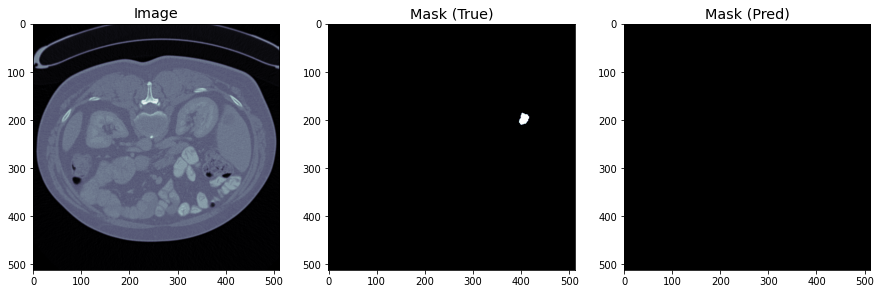

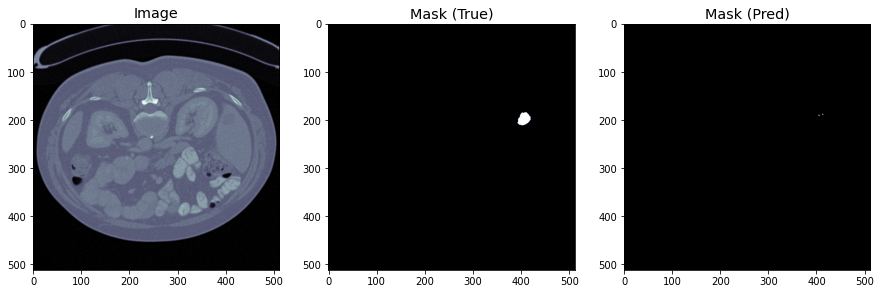

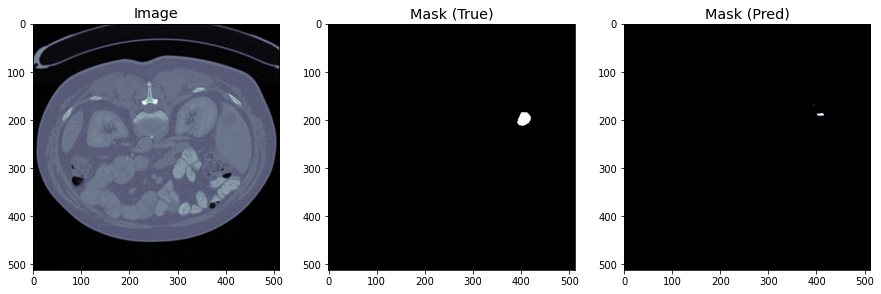

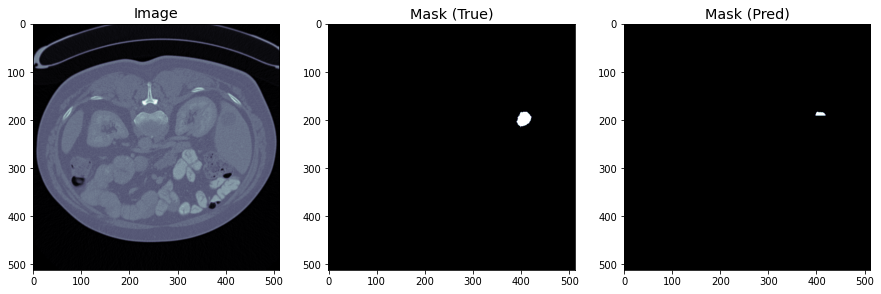

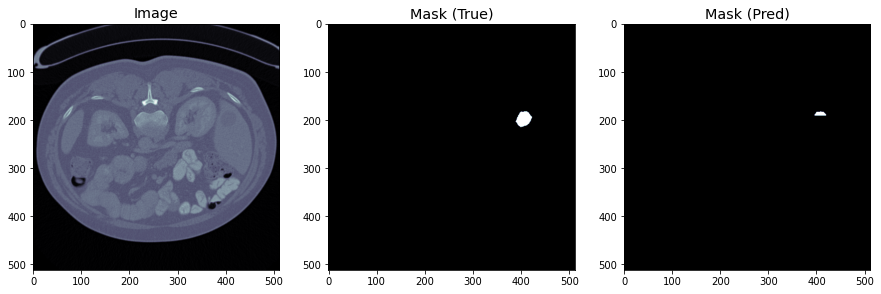

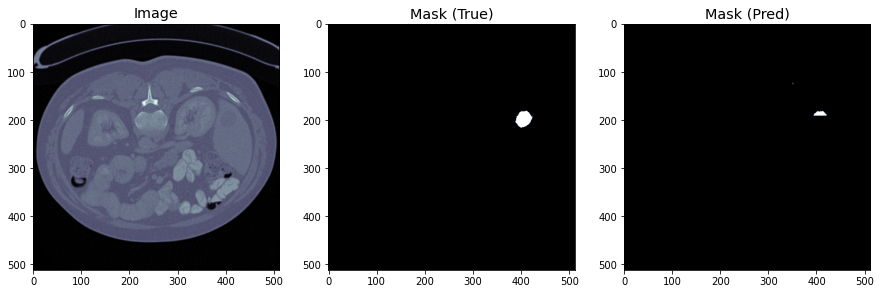

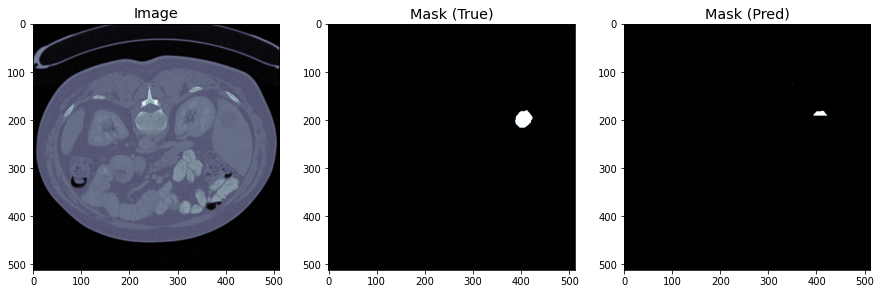

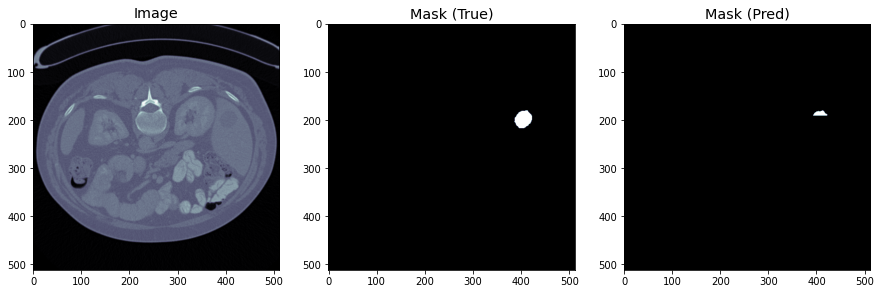

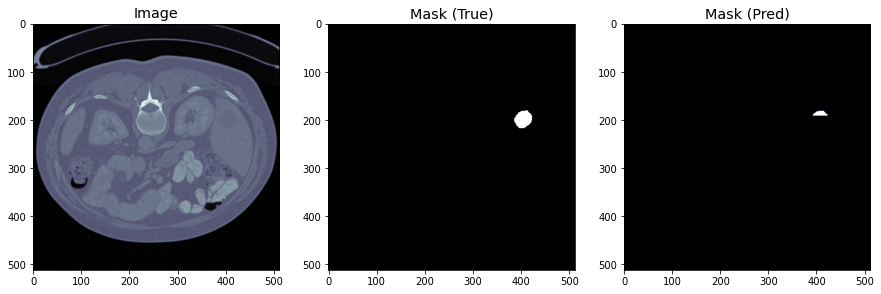

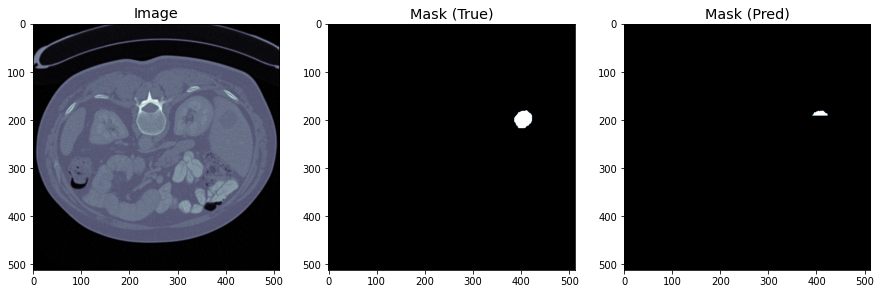

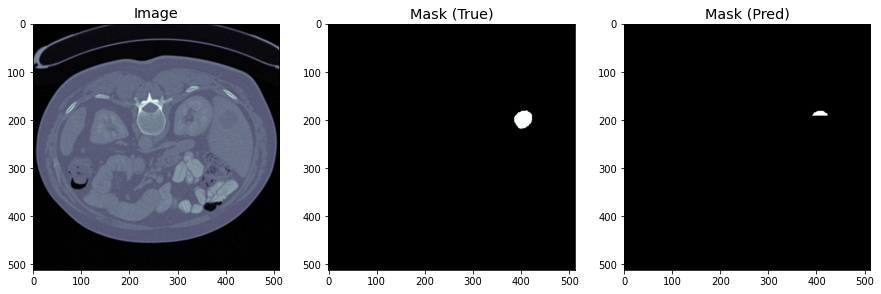

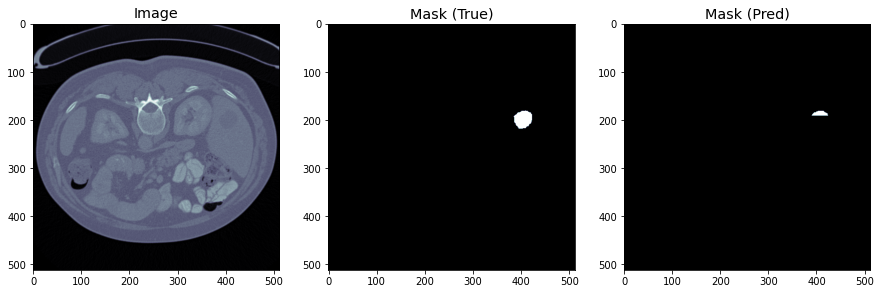

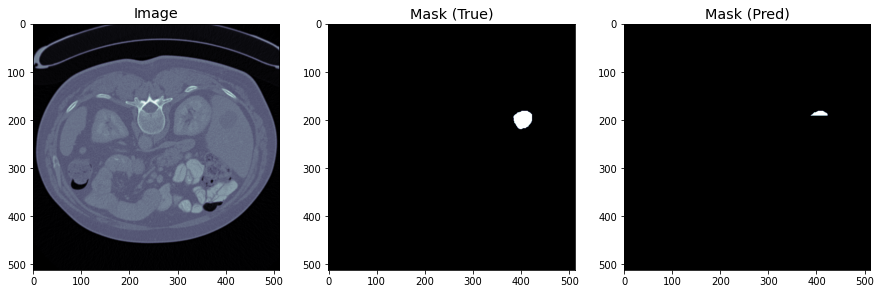

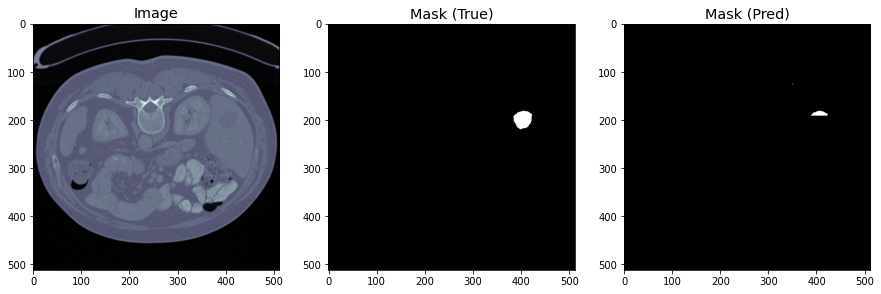

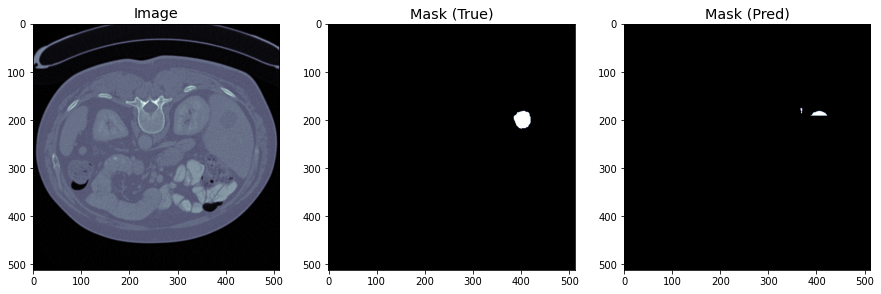

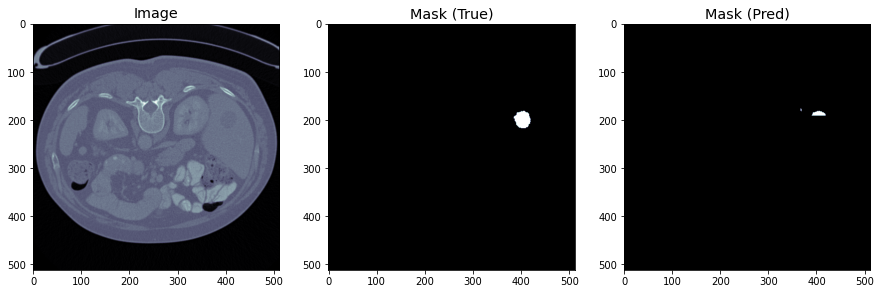

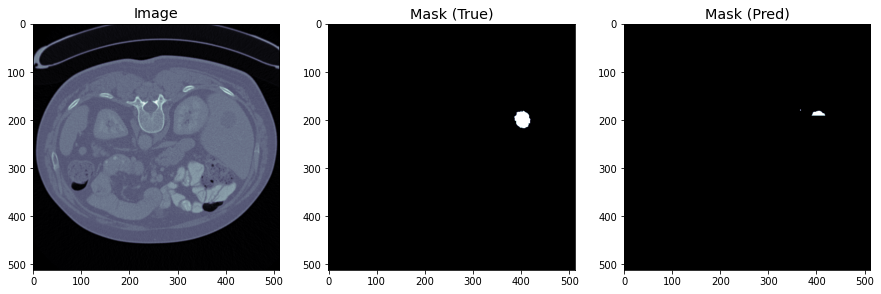

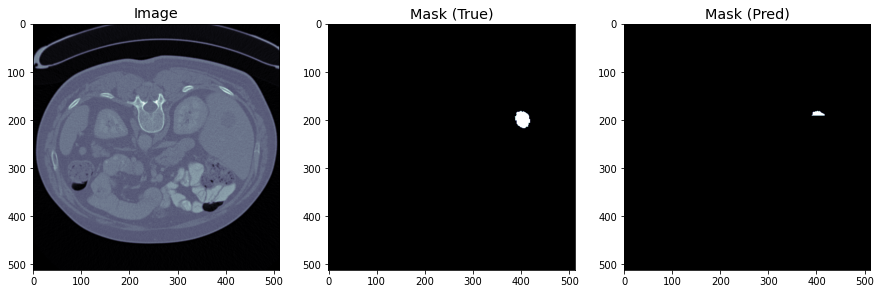

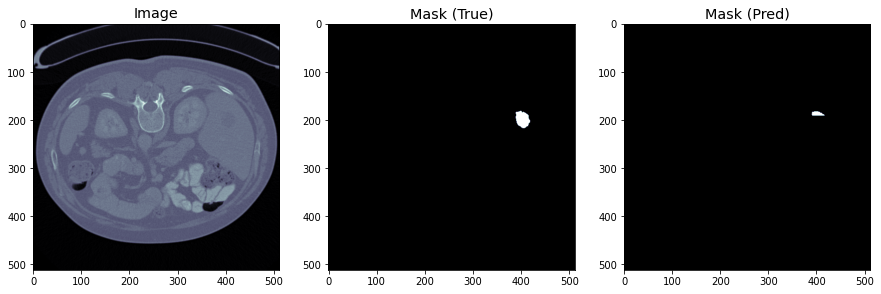

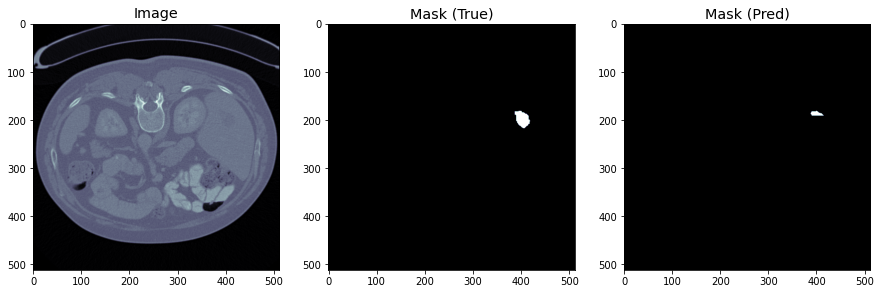

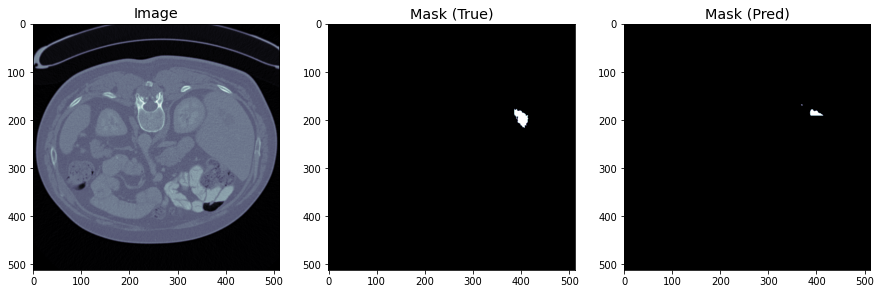

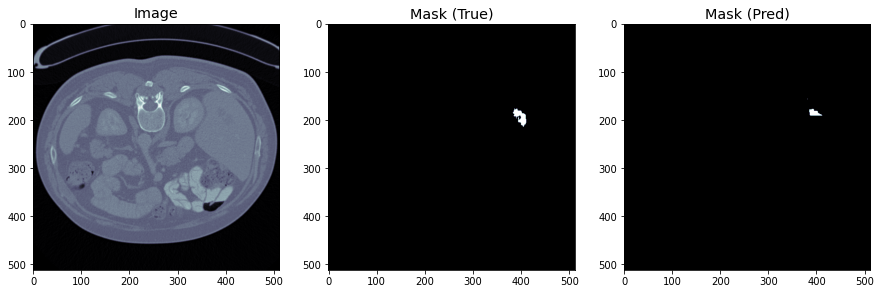

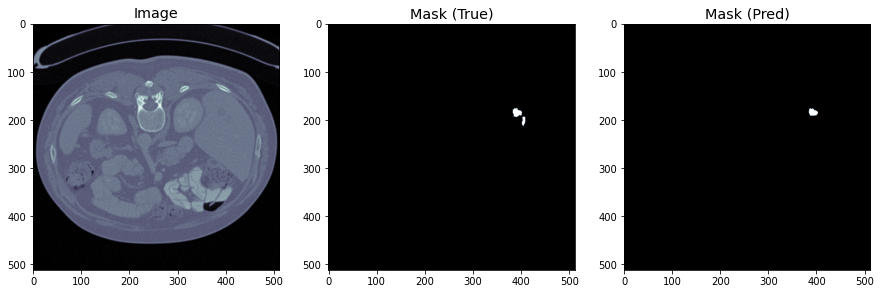

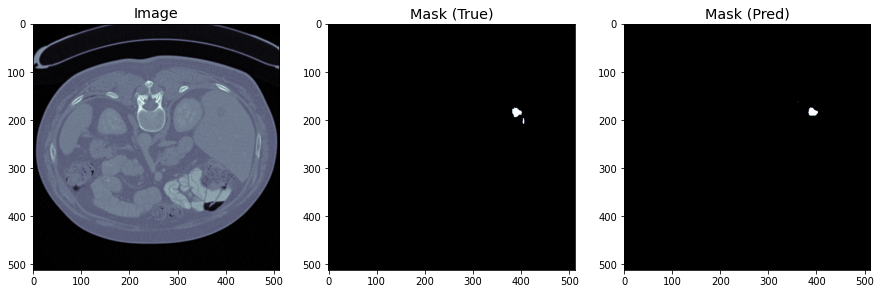

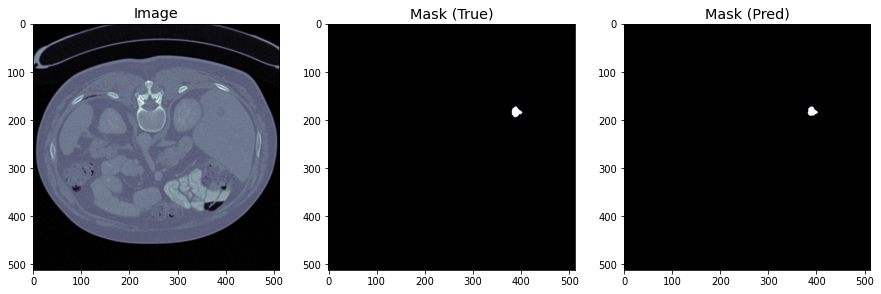

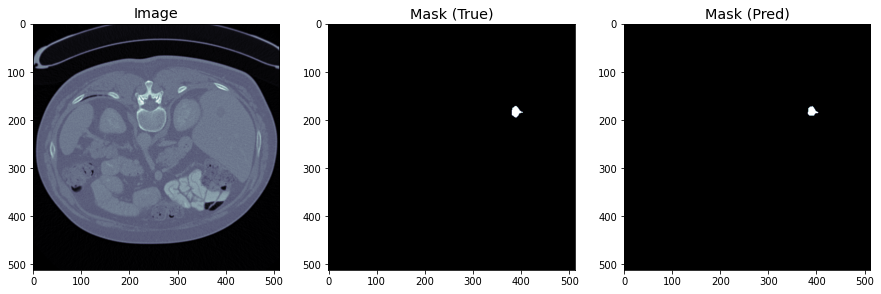

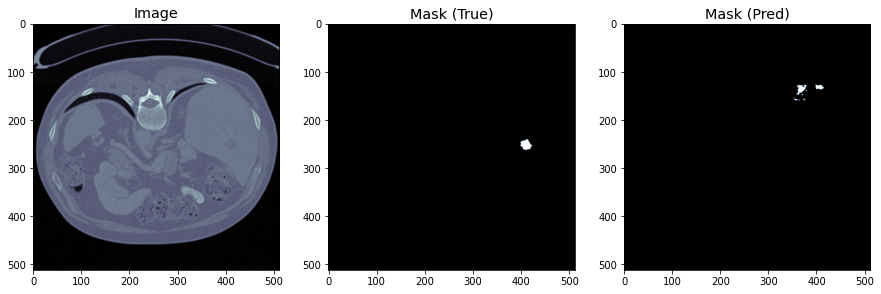

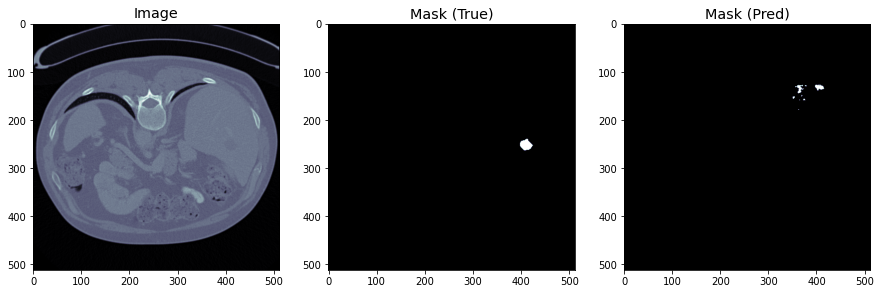

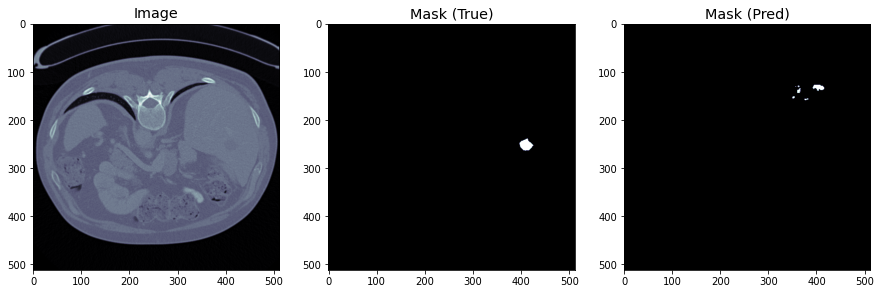

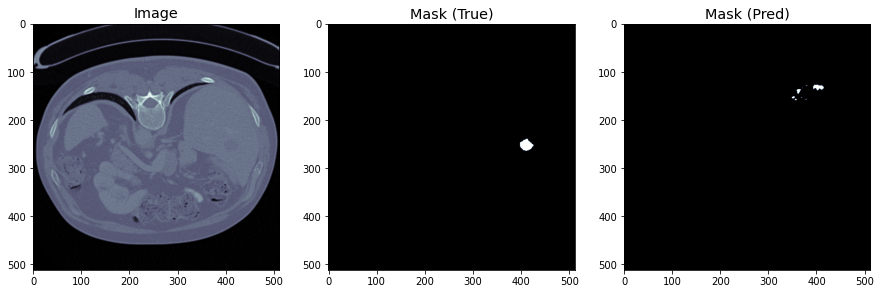

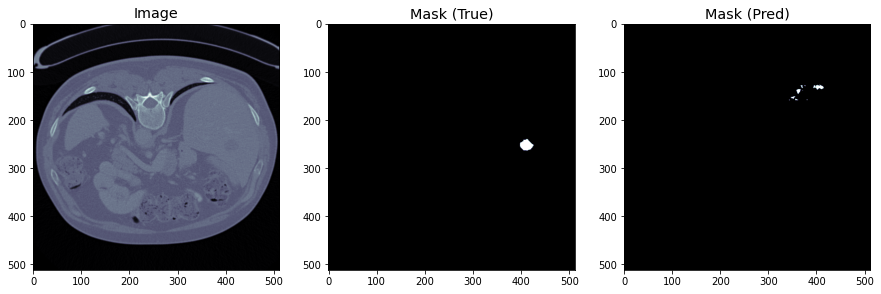

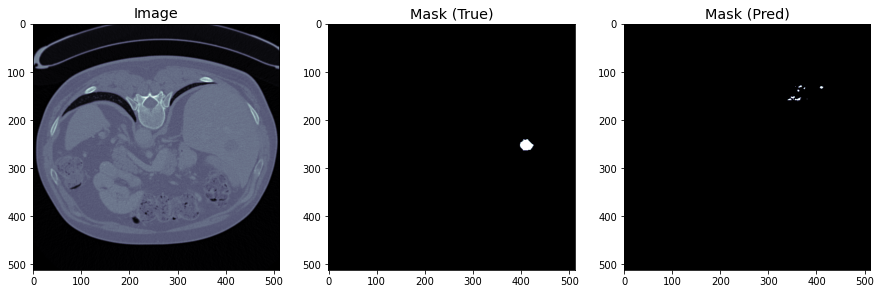

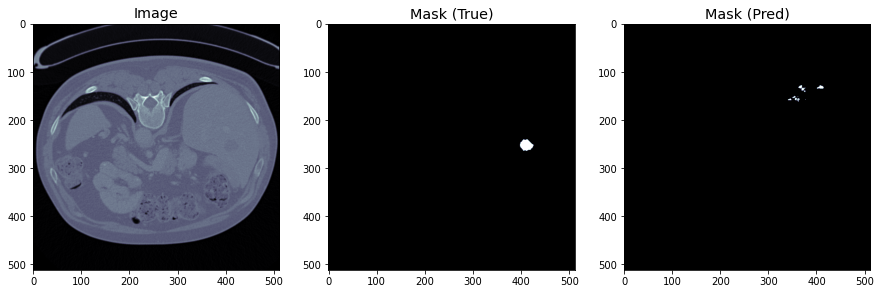

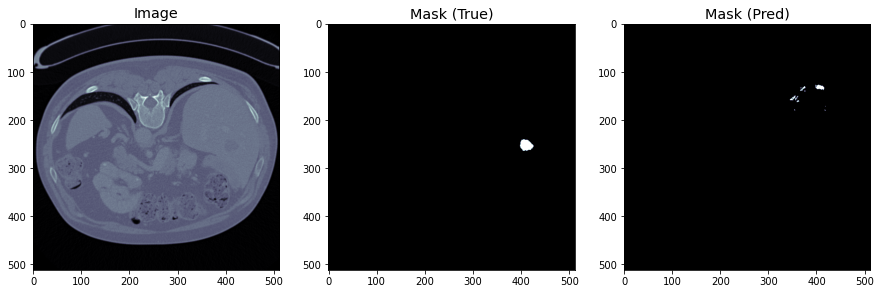

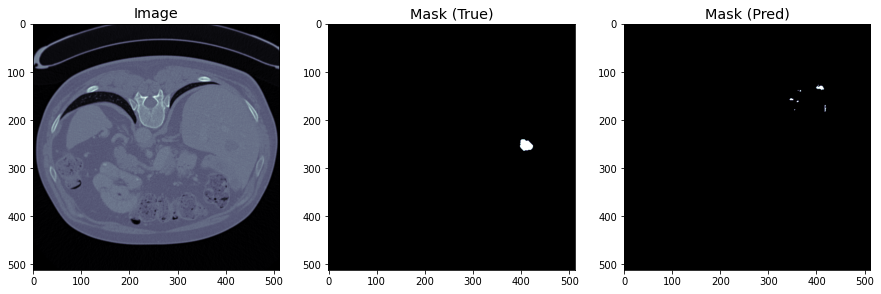

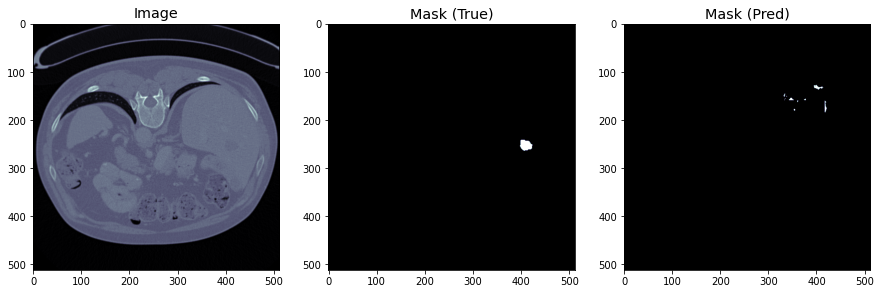

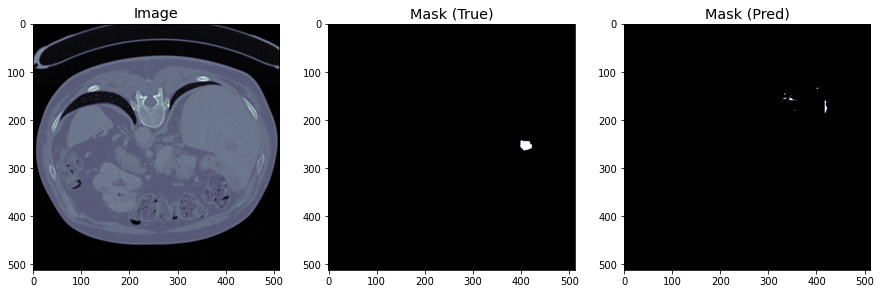

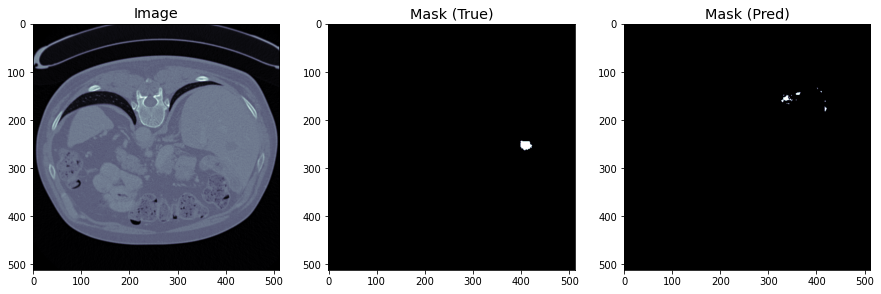

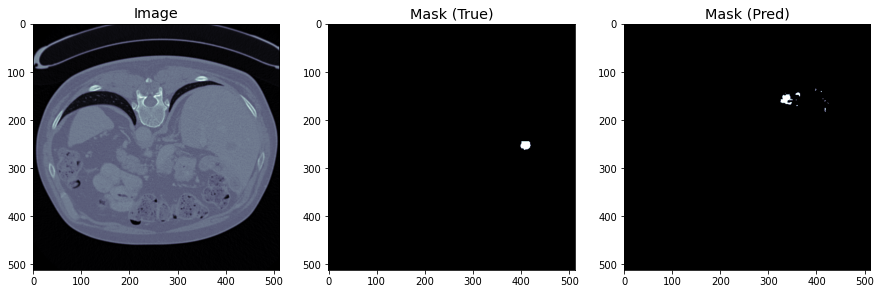

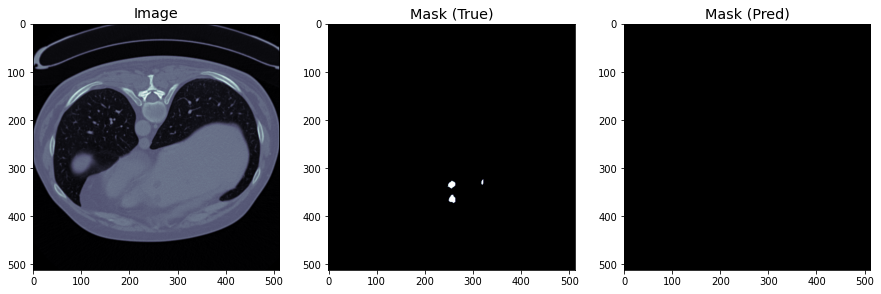

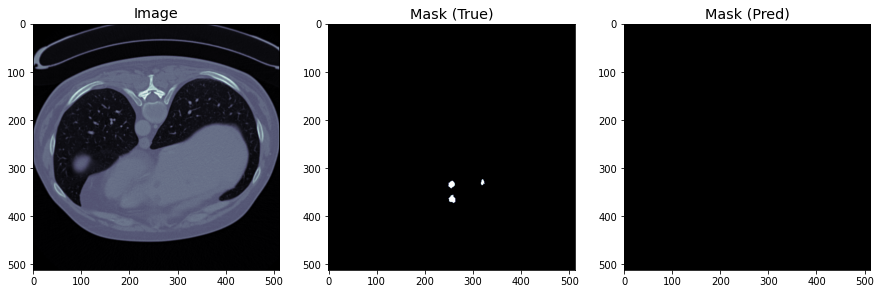

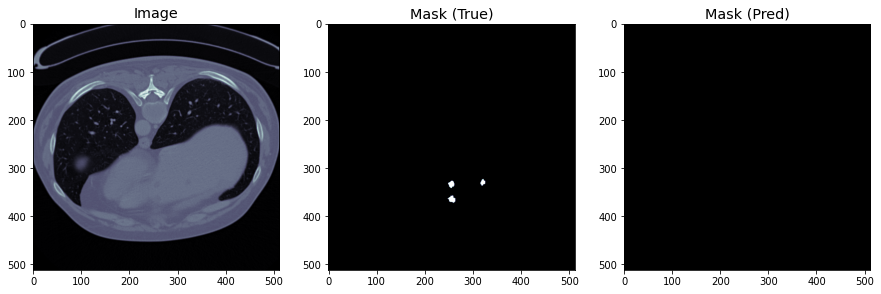

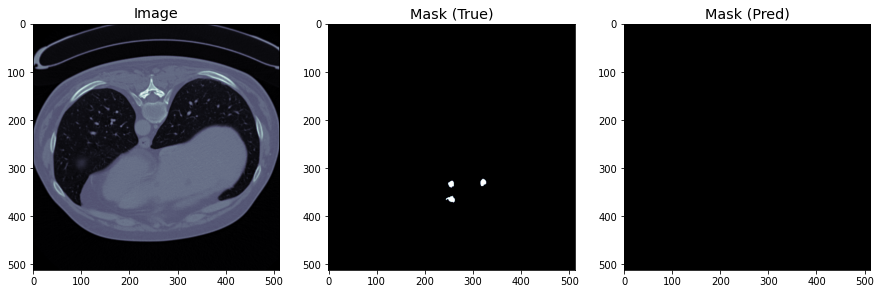

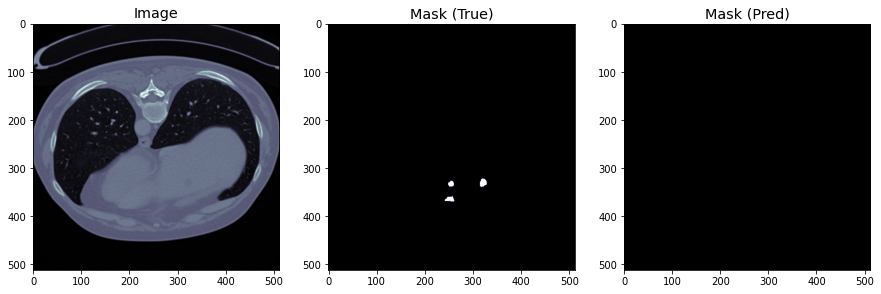

In [14]:
import keras
from keras.models import load_model
model = keras.models.Sequential() 
input_shape = [64, 64, 1]

Datapath='/content/drive/My Drive/Training Batch 2'

print(Datapath)

imgdata=[]

img_path2 = sorted(glob(Datapath+"/volume-*.nii"))
mask_path2 = sorted(glob(Datapath+"/segmentation-*.nii"))


from keras.models import load_model 

loaded_model = load_model("/content/UNet_Liver.hdf5", compile=False)
print("Loaded model from disk")

img_ex = nib.load(img_path[25]).get_data()
mask_ex = nib.load(mask_path[25]).get_data()

mask_ex[mask_ex == 1] = 0


for i in range(mask_ex.shape[2]):
    _, count = np.unique(mask_ex[:, :, i], return_counts=True)
    
    if len(count) > 1 and count[1] > 300:
        
        patch_ex = slice_to_patch(img_ex[:, :, i], patch_ratio)
        prediction = loaded_model.predict(patch_ex)
        prediction_mask = patch_to_slice(prediction, patch_ratio, input_shape, conf_threshold = 0.97)
        
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize = ((15, 15)))
        
        ax1.imshow(np.rot90(img_ex[:, :, i], 3), cmap = 'bone')
        ax1.set_title("Image", fontsize = "x-large")
        ax1.grid(False)
        ax2.imshow(np.rot90(mask_ex[:, :, i], 3), cmap = 'bone')
        ax2.set_title("Mask (True)", fontsize = "x-large")
        ax2.grid(False)
        ax3.imshow(np.rot90(prediction_mask.reshape((512, 512)), 3), cmap = 'bone')
        ax3.set_title("Mask (Pred)", fontsize = "x-large")
        ax3.grid(False)
        plt.show()